# Summary

## Task

To explore dependency parsing for sentences so that word level graphs can be constructed for the problem of classification

1. Explore how dependency parsing works
2. Tokenize sentences and give them to the dependency parser
3. Obtain the relationships and check them
4. Convert the dependency graphs from the parser into the graphs that can be used for GCN
5. Explore GCN and try to build graphs from the parsed dependency graphs
6. Perform graph level classification
7. Check performance
8. Refine the various layers and hyperparameters in the process
9. Check final performance
10. Do interpreation manually on some selected examples
11. Implement edge masking to get the minimum subgraph
12. Performe automatic interpretation of the graphs to determine the most important terms/relationships for each sentence

## Method

* For dependency parsing, we will try to use the tools from the stanford nlp group.
* The *[CoreNLP](https://github.com/stanfordnlp/CoreNLP)* library is important as it contains many of the tools needed to performe dependency parsing
* The *[stanza](https://github.com/stanfordnlp/stanza)* library offers a wrapped version of CoreNLP that works directly with Python
* Visualization of the graphs can be done using *[networkx](https://github.com/networkx/networkx)*
* For GCN and word-level graphs we will primarily look at the ideas in this *[tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html)*
* We will try to use the *[spektral](https://github.com/danielegrattarola/spektral/)* library to implement the graphs convolution and attention 
* *[Link](https://universaldependencies.org/u/dep/)* to explaination of dependency relations.

## Dataset

The dataset is still IMDB review but we may expand later on

## Results

Fill in later

## Conclusion

Fill in at the end

# Code

## Basic Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
import networkx as nx
import spacy

In [ ]:
stanza.download('en')

In [ ]:
import stanzaTools

## Part 1: Dependency Parsing

### Testing Stanza

In [ ]:
sampleSentence = "There is nothing wrong with Apple's new M1 Max Chip, everything works so well! Ok this might be kind of difficult."

In [ ]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

In [ ]:
doc = nlp(sampleSentence)

In [ ]:
doc.sentences[0]

In [ ]:
sent_dict = doc.sentences[0].to_dict()

#### tokenRelationHead

In [ ]:
stanzaTools.tokenRelationHead(sent_dict)

#### getNodeEdgeLists

In [ ]:
def getNodeEdgeLists(doc):
    """
    Parses all the edges in sent_dict and extracts the edges, node labels, and edge labels.
    Args:
        doc - (stanza.models.common.doc.Document) The doc object
    Returns:
        nodeList - (list) A list of dictionaries, the keys are the same as the items inside a sentence object.
        edgeList - (list) A list of dictionaries, the keys are "edgePair", "edgeLabel"
    """
    edgeList = []
    nodeList = []
    modifier = 0 
    wordLimit = 50
    maxSentences = 3
    sentences = []
    for sentence in doc.sentences:
        if sentence.sentiment != 1:
            sentences.append(sentence)
    sentences = sentences[0:3]
    for sentence in sentences:
        for node in sentence.to_dict()[0:wordLimit]:
            node['id'] += modifier
            node['head'] += modifier
            nodeList.append(node)
            
            # if modifier and node['id'] == modifier + 1:
            #     edgePair = (node['id'] - 1, node['id'])
            #     edgeLabel = 'nextSentence'
            #     edgeList.append(
            #         {
            #             "edgePair" : edgePair,
            #             "edgeLabel" : edgeLabel
            #         }
            #     )
            if (node['head'] != modifier and node['head'] <= modifier + wordLimit):
                # the first is the head and the second is dependent
                edgePair = (node['head'], node['id'])
                edgeLabel = node['deprel']
                edgeList.append(
                    {
                        "edgePair" : edgePair,
                        "edgeLabel" : edgeLabel,
                    }
                )
        modifier += len(sentence.to_dict()[0:wordLimit])

    return nodeList, edgeList

In [ ]:
doc

In [ ]:
nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)

In [ ]:
doc

In [ ]:
nodeList

#### drawDepGraph

In [ ]:
stanzaTools.drawDepGraph(nodeList, edgeList)

### Testing Spacy (Ignore for Now)

In [ ]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
text = sampleSentence
doc = nlp(text)
# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)    

In [ ]:
spacy.displacy.render(doc, style='dep', jupyter=True, options={'distance': 120})

In [ ]:
doc

### Testing TF Datasets

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import spacy
import tfDatasetTools
nlp = spacy.load("en_core_web_sm")

In [ ]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

In [ ]:
part = testDS.take(10)

#### decodeZeroDimTensor

#### convertTakeDataset

In [ ]:
features, labels = tfDatasetTools.convertTakeDataset(part)

In [ ]:
features[0]

In [ ]:
labels

In [ ]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

In [ ]:
doc = nlp(features[1])
for sentence in doc.sentences:
    print(sentence.text)
    print(sentence.sentiment)

In [ ]:
doc.sentences[1]

### Testing spektral

In [ ]:
import spektral
from spektral.datasets import TUDataset

In [ ]:
dataset = TUDataset('PROTEINS')

In [ ]:
dataset

In [ ]:
train_datset = dataset[:100]

In [ ]:
test_datset = dataset[100:]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool

In [ ]:
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.5)
        self.dense = Dense(n_labels, 'softmax')

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out

In [ ]:
model = MyFirstGNN(32, dataset.n_labels)
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from spektral.data import BatchLoader

loader = BatchLoader(train_datset, batch_size=32)
testLoader = BatchLoader(test_datset, batch_size=32)

In [ ]:
model.fit(loader.load(),steps_per_epoch=loader.steps_per_epoch, epochs=10)

In [ ]:
model.evaluate(testLoader.load(),steps=testLoader.steps_per_epoch)

In [ ]:
test_datset[12].y

## Part 2: Graph Networks

### Basic Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
import networkx as nx
import tensorflow_hub as hub
import tensorflow_text
import spektral

In [117]:
import stanzaTools
import tfDatasetTools
import relationEncoder

### Set up Stanza

In [3]:
stanza.download('en')

2022-05-29 15:29:13 INFO: Downloading default packages for language: en (English)...
2022-05-29 15:29:14 INFO: File exists: /Users/zeyuyang/stanza_resources/en/default.zip
2022-05-29 15:29:17 INFO: Finished downloading models and saved to /Users/zeyuyang/stanza_resources.


In [4]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

2022-05-29 15:29:17 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-05-29 15:29:18 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

2022-05-29 15:29:18 INFO: Use device: cpu
2022-05-29 15:29:18 INFO: Loading: tokenize
2022-05-29 15:29:18 INFO: Loading: pos
2022-05-29 15:29:18 INFO: Loading: lemma
2022-05-29 15:29:18 INFO: Loading: depparse
2022-05-29 15:29:18 INFO: Loading: sentiment
2022-05-29 15:29:18 INFO: Done loading processors!


#### createGraph

In [5]:
from importlib import reload
reload(stanzaTools)
reload(tfDatasetTools)

<module 'tfDatasetTools' from '/Users/zeyuyang/Projects/CS397Project/tfDatasetTools.py'>

In [138]:
relationsDict = relationEncoder.getRelationsDict()

In [262]:
def createGraph(doc, positive):
    startTime = time.perf_counter()
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)
    nodeTime = time.perf_counter()
    words = [item['text'] for item in nodeList]
    convertedFeatures = stanzaTools.convertToEmbedding(words, preprocessor, encoder)
    adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    convertTime = time.perf_counter()
    edgeFeatures = relationEncoder.OneHotEncode(relationsDict, [edge['edgeLabel'] for edge in edgeList])
    encodeTime = time.perf_counter()
    label = np.array([positive])
    print([nodeTime - startTime, convertTime  - nodeTime, encodeTime - convertTime])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, edgeFeatures, label)

### Load Data

In [141]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

#### Set a Limit

In [223]:
trainLimit = 20
testLimit = 20

trainSubset = trainDS.take(trainLimit)
testSubset = testDS.take(testLimit)

In [224]:
validationSplit = 0.5
validationIndex = int(validationSplit * trainLimit)

validationSplitSubset = trainSubset.take(validationIndex)
trainSplitSubset = trainSubset.skip(validationIndex)

In [225]:
trainFeatures, trainLabels = tfDatasetTools.convertTakeDataset(trainSplitSubset)
valFeatures, valLabels = tfDatasetTools.convertTakeDataset(validationSplitSubset)
testFeatures, testLabels = tfDatasetTools.convertTakeDataset(testSubset)

2022-05-29 20:25:08.140155: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-29 20:25:08.156612: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-29 20:25:08.173549: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. I

##### Checking trainFeatures and functions

In [226]:
print(trainFeatures[0])

During a sleepless night, I was switching through the channels & found this embarrassment of a movie. What were they thinking?  If this is life after "Remote Control" for Kari (Wuhrer) Salin, no wonder she's gone nowhere.  And why did David Keith take this role? It's pathetic!  Anyway, I turned on the movie near the end, so I didn't get much of the plot. But this must've been the best part. This nerdy college kid brings home this dominatrix-ish girl...this scene is straight out of the comic books -- or the cheap porn movies. She calls the mother anal retentive and kisses the father "Oh, I didn't expect tongue!" Great lines!  After this, I had to see how it ended..  Well, of course, this bitch from hell has a helluva past, so the SWAT team is upstairs. And yes...they surround her! And YES YES! The kid blows her brains out!!!! AHAHHAHAHAHA!!  This is must-see TV.   


In [146]:
doc = nlp(trainFeatures[0])

In [147]:
for sentence in doc.sentences:
    print(sentence.text)
    print(sentence.sentiment)

I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot.
0
However on this occasion I fell asleep because the film was rubbish.
0
The plot development was constant.
1
Constantly slow and boring.
0
Things seemed to happen, but with no explanation of what was causing them or why.
0
I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else.
0
I cant recommend this film at all.
2


In [148]:
nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)

In [149]:
nodeList[0:5]

[{'id': 1,
  'text': 'I',
  'lemma': 'I',
  'upos': 'PRON',
  'xpos': 'PRP',
  'feats': 'Case=Nom|Number=Sing|Person=1|PronType=Prs',
  'head': 4,
  'deprel': 'nsubj:pass',
  'start_char': 0,
  'end_char': 1},
 {'id': 2,
  'text': 'have',
  'lemma': 'have',
  'upos': 'AUX',
  'xpos': 'VBP',
  'feats': 'Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin',
  'head': 4,
  'deprel': 'aux',
  'start_char': 2,
  'end_char': 6},
 {'id': 3,
  'text': 'been',
  'lemma': 'be',
  'upos': 'AUX',
  'xpos': 'VBN',
  'feats': 'Tense=Past|VerbForm=Part',
  'head': 4,
  'deprel': 'aux:pass',
  'start_char': 7,
  'end_char': 11},
 {'id': 4,
  'text': 'known',
  'lemma': 'know',
  'upos': 'VERB',
  'xpos': 'VBN',
  'feats': 'Tense=Past|VerbForm=Part|Voice=Pass',
  'head': 0,
  'deprel': 'root',
  'start_char': 12,
  'end_char': 17},
 {'id': 5,
  'text': 'to',
  'lemma': 'to',
  'upos': 'PART',
  'xpos': 'TO',
  'head': 6,
  'deprel': 'mark',
  'start_char': 18,
  'end_char': 20}]

In [150]:
adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))

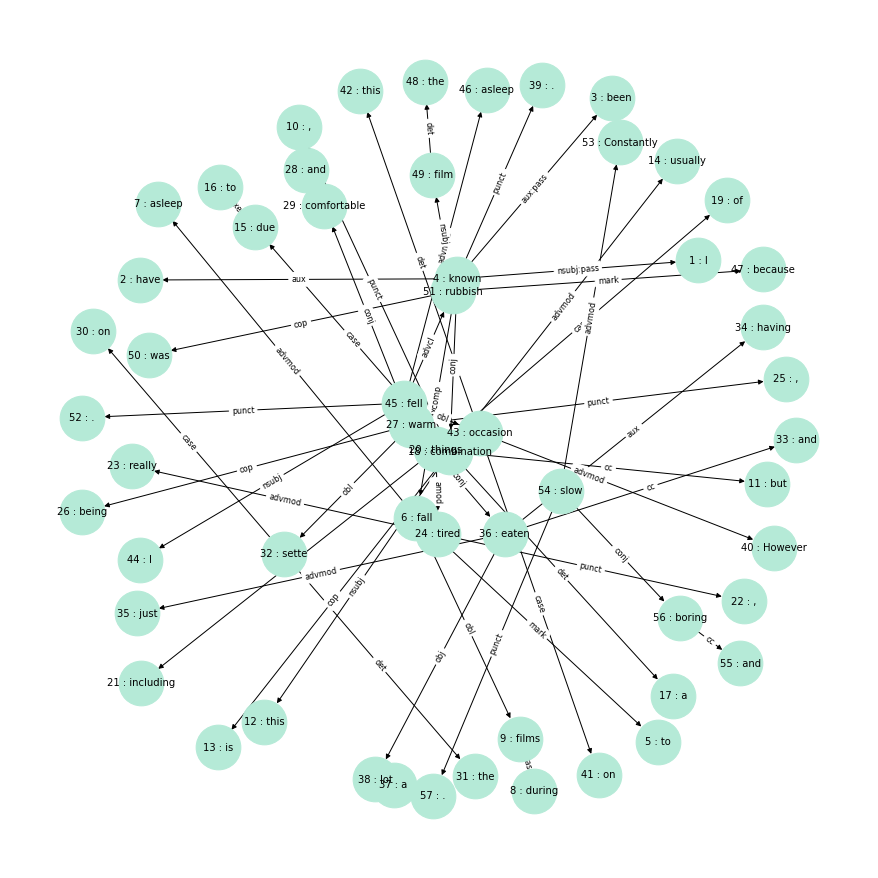

In [151]:
stanzaTools.drawDepGraph(nodeList, edgeList)

#### Bert Embeddings

In [152]:
tf.keras.backend.clear_session()

In [153]:
# Preprocess and encode input
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2',trainable=False)

outputs = encoder(encoder_inputs)

pooled_output = outputs['pooled_output'] # [batch_size, 128].
# [batch_size, seq_length, 128].

sequence_output = outputs['sequence_output']

2022-05-29 20:10:42.877579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


##### Sample Convert to Embedding

In [159]:
text = "hello there who are you hello there who are you hello there who are you hello there who are you hello there who are you hello there who are you"
words = text.split()
converted = stanzaTools.convertToEmbedding(words, preprocessor, encoder)

In [160]:
converted.shape

(30, 128)

In [163]:
converted = stanzaTools.convertToEmbedding(['!'], preprocessor, encoder)

In [164]:
word = ['hello', 'there']
convertedWords = stanzaTools.convertToEmbedding(word, preprocessor, encoder)

In [165]:
convertedWords.shape

(2, 128)

##### Example non-graph Model

In [ ]:
def sampleModel():
    inputs = text_input
    preprocessorLayer = preprocessor(inputs)['input_word_ids']
    
    embedding_layer = tf.keras.layers.Embedding(10000,
                                                128)(preprocessorLayer)
    # embedding_layer = encoder(preprocessorLayer)['pooled_output']
    
    flatten = tf.keras.layers.Flatten()(embedding_layer)
    dense_layer = tf.keras.layers.Dense(16, activation='relu')(flatten)
    outputs = tf.keras.layers.Dense(1)(dense_layer)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
tf.keras.backend.clear_session()
model = sampleModel()
model.summary()

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    trainFeatures,
    trainLabels,
    validation_data=(valFeatures, valLabels),
    epochs=20,
    verbose=1)

In [ ]:
results = model.evaluate(x=testFeatures, y=testLabels)
print(results)

### Convert Data to Graph Format

In [228]:
trainGraphs = []
for i in range(len(trainFeatures)):
    sentence = trainFeatures[i]
    label = trainLabels[i]
    doc = nlp(sentence)
    newGraph = createGraph(doc, label)
    trainGraphs.append(newGraph)

2022-05-29 20:26:20.939451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 20:26:21.235888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [229]:
len(trainGraphs)

10

In [240]:
sentences = []
labels = []
for i in range(len(trainFeatures)):
    sentence = trainFeatures[i]
    label = trainLabels[i]
    sentences.append(sentence)
    labels.append(label)

In [246]:
import time

In [257]:
startTime = time.perf_counter()
docs = []
for sentence in sentences:
    doc = nlp(sentence)
    docs.append(doc)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

4.276242957999784


In [254]:
performanceTest = []

In [264]:
startTime = time.perf_counter()
for i in range(len(docs)):
    doc = docs[i]
    label = labels[i]
    newGraph = createGraph(doc, label)
    performanceTest.append(newGraph)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

[0.000859291001688689, 0.40942295900094905, 1.716599945211783e-05]
[0.0010349169970140792, 2.1251106250019802, 3.83749975298997e-05]
[0.0007792910000716802, 1.77322333399934, 4.9791000492405146e-05]
[0.0008092909993138164, 1.4423700840015954, 2.8832997486460954e-05]
[0.0006208750019141007, 0.9144882500004314, 2.3666998458793387e-05]
[0.00018395799997961149, 0.1375348750007106, 1.2583001080201939e-05]
[0.0007279169985849876, 1.1104839170002379, 2.787500125123188e-05]
[0.0003725830028997734, 0.43011016699892934, 2.0457999198697507e-05]
[0.0006801250019634608, 1.446266208000452, 4.958299905410968e-05]
[0.0008318340005644131, 1.6648500000010245, 3.3958000130951405e-05]
11.462327249999362


In [230]:
validationGraphs = []

for i in range(len(valFeatures)):
    sentence = valFeatures[i]
    label = valLabels[i]
    doc = nlp(sentence)
    newGraph = createGraph(doc, label)
    validationGraphs.append(newGraph)

In [231]:
len(validationGraphs)

10

#### Custom Graph Datasets

In [172]:
from spektral.data import Dataset 
from spektral.data.graph import Graph
import os

In [195]:
class TrainDataset(Dataset):
    """
    A dataset of train graphs.
    """
    def __init__(self, **kwargs):
        # self.path = savePath
        self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(trainGraphs)):
            x = trainGraphs[i][0]
            a = trainGraphs[i][1]
            e = trainGraphs[i][2]
            y = trainGraphs[i][3]

            filename = os.path.join(self.path, f'graph_{i}')
            np.savez(filename, x=x, a=a, e=e, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(trainGraphs)):
            data = np.load(os.path.join(self.path, f'graph_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
            )
        return output

In [196]:
class ValDataset(Dataset):
    """
    A dataset of val graphs.
    """
    def __init__(self, **kwargs):
        # self.path = savePath
        self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(validationGraphs)):
            x = validationGraphs[i][0]
            a = validationGraphs[i][1]
            e = validationGraphs[i][2]
            y = validationGraphs[i][3]

            filename = os.path.join(self.path, f'graph_val_{i}')
            np.savez(filename, x=x, a=a, e=e, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(validationGraphs)):
            data = np.load(os.path.join(self.path, f'graph_val_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
            )
        return output

In [197]:
def loadValGraph(graphDir, index):
    data = np.load(os.path.join(graphDir, f'graph_val_{index}.npz'), allow_pickle=True)
    graph = Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
    return graph

def loadTrainGraph(graphDir, index):
    data = np.load(os.path.join(graphDir, f'graph_{index}.npz'), allow_pickle=True)
    graph = Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
    return graph

In [198]:
# to load prev generated val graphs
# valGraphDir = '/Users/zeyuyang/spektral/datasets/ValDataset'
# valGraphNum = 100
# validationGraphs = [loadValGraph(valGraphDir, i) for i in range(valGraphNum)]

In [204]:
valDataset = ValDataset()
valDataset

ValDataset(n_graphs=1)

In [202]:
# to load prev generated train graphs
# trainGraphDir = '/Users/zeyuyang/spektral/datasets/TrainDataset'
# trainGraphNum = 100
# trainGraphs = [loadTrainGraph(trainGraphDir, i) for i in range(trainGraphNum)]

In [205]:
trainDataset = TrainDataset()
trainDataset

TrainDataset(n_graphs=1)

### Model and Training

In [206]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Embedding
from spektral.layers import GCNConv, GlobalSumPool

In [219]:
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.graph_conv2 = GCNConv(16)
        self.graph_conv3 = GCNConv(16)
        self.graph_conv4 = GCNConv(4)
        self.pool = GlobalSumPool()
        self.AGNNCONV = spektral.layers.AGNNConv(trainable=True, aggregate='sum', activation=None)
        self.GenConv = spektral.layers.GeneralConv(channels=n_hidden, batch_norm=True, dropout=0.0,
                                                   aggregate='sum', activation='prelu', use_bias=True,
                                                   kernel_initializer='glorot_uniform', bias_initializer='zeros',
                                                   kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                                                   kernel_constraint=None, bias_constraint=None)
        self.graphAtten = spektral.layers.GATConv(channels=n_hidden, attn_heads=5,
                                                  concat_heads=True, dropout_rate=0.2, return_attn_coef=False,
                                                  add_self_loops=True, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                                  bias_initializer='zeros', attn_kernel_initializer='glorot_uniform', kernel_regularizer=None,
                                                  bias_regularizer=None, attn_kernel_regularizer=None, activity_regularizer=None,
                                                  kernel_constraint=None, bias_constraint=None, attn_kernel_constraint=None)
        self.maxPool = spektral.layers.GlobalMaxPool()
        self.dropout = Dropout(0.2)
        self.dense1 = Dense(64, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.dense2 = Dense(16, activation='relu')
        self.dense = Dense(1, 'sigmoid')

    def call(self, inputs):
        x, a, e, i = inputs
        x = self.graph_conv([x,a])
        # x = self.graph_conv2([x,a])
        # x = self.graph_conv3([x,a])
        # x = self.graph_conv4([x,a])
        # out = self.pool(out)
        out = self.maxPool([x, i])
        # out = self.dense1(out)
        out = self.dropout2(out)
        # out = self.dense2(out)
        out = self.dense(out)
        return out

In [212]:
tf.keras.backend.clear_session()
model = MyFirstGNN(64, 1)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy',])

In [213]:
from spektral import models

In [214]:
# tf.keras.backend.clear_session()
# model = spektral.models.general_gnn.GeneralGNN(1, activation=None, hidden=256, message_passing=4, pre_process=2, post_process=2, connectivity='cat', batch_norm=True, dropout=0.0, aggregate='sum', hidden_activation='prelu', pool='sum')
# model.compile('adam', 'binary_crossentropy', metrics=['accuracy',])

In [215]:
from spektral.data import BatchLoader

# trainLoader = BatchLoader(trainDataset, node_level=False, batch_size=10, epochs=None, shuffle=True)
trainLoader = spektral.data.loaders.DisjointLoader(trainDataset, node_level=False, batch_size=20, epochs=None, shuffle=True)

# testLoader = BatchLoader(valDataset, node_level=False, batch_size=10)
testLoader = spektral.data.loaders.DisjointLoader(valDataset, node_level=False, batch_size=20)

In [216]:
trainDataset[0]

Graph(n_nodes=57, n_node_features=128, n_edge_features=51, n_labels=1)

In [222]:
history = model.fit(trainLoader.load(),
              validation_data=testLoader.load(),
              steps_per_epoch=trainLoader.steps_per_epoch,
              validation_steps=testLoader.steps_per_epoch,
              epochs=20)

Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3878e-06 - val_accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.2226e-06 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 44ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.1399e-06 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 42ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.1399e-06 - val_accuracy: 1.0000
Epoch 5/20


/Users/zeyuyang/miniforge3/envs/graphLearning/lib/python3.9/site-packages/spektral-1.1.0-py3.9.egg/spektral/data/utils.py:221: UserWarning: you are shuffling a 'TrainDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1/1 [==============================] - 0s 44ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.9747e-06 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 44ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.8920e-06 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 72ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.8920e-06 - val_accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.7268e-06 - val_accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 47ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.7268e-06 - val_accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 42ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.7268e-06 - val_accuracy: 1.0000
Epoch 11/20
1/1 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.6441e-06 - v

In [220]:
model.evaluate(testLoader.load(), steps=testLoader.steps_per_epoch)
# model.evaluate(trainLoader.load(), steps=trainLoader.steps_per_epoch)

1/1 [==============================] - 0s 26ms/step - loss: 3.4704e-06 - accuracy: 1.0000


[3.4704426070675254e-06, 1.0]

In [221]:
model.predict(testLoader.load(), steps=testLoader.steps_per_epoch)

2022-05-29 20:24:34.376787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/zeyuyang/miniforge3/envs/graphLearning/lib/python3.9/site-packages/spektral-1.1.0-py3.9.egg/spektral/data/utils.py:221: UserWarning: you are shuffling a 'ValDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


array([[3.5089608e-06]], dtype=float32)

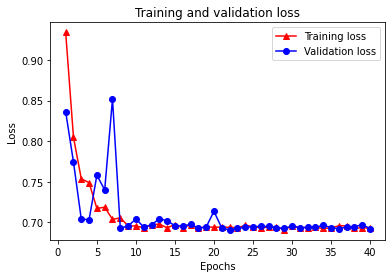

In [299]:
# plot training and validaiton loss over epochs
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

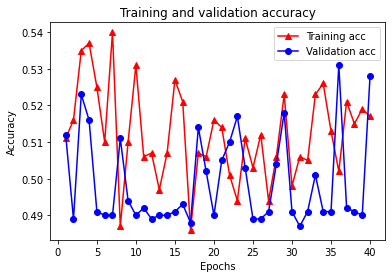

In [300]:
# plot training and validation accuracy over epochs
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

In [62]:
from spektral.datasets import QM9

In [63]:
dataset = QM9(amount=1000)  

44867584/44852087 [==============================] - 43s 1us/step
Loading QM9 dataset.
Reading SDF


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2878.29it/s]


In [ ]:
x[0]

Graph(n_nodes=107, n_node_features=128, n_edge_features=None, n_labels=1)